# Simsurvey demo

In [1]:
import os
home_dir = os.getcwd()

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

In [2]:
import simsurvey
import numpy as np
import matplotlib.pyplot as plt

import sncosmo
from astropy.cosmology import Planck15

import simsurvey_tools as sst
from scipy.interpolate import RectBivariateSpline as Spline2d

import ligo.skymap.plot

In [3]:
simsurvey.__version__

'0.7.0.dev1'

In [4]:
# Load the ZTF fields, CCD corners and filters
fields = sst.load_ztf_fields()
sst.load_ztf_filters()

In [5]:
# Load the ZTF CCD corners 
ccds = sst.load_ztf_ccds()

In [6]:
# Load the ZTF quadrants corners 
ccds = sst.load_ztf_ccds(filename='data/ZTF_corners_rcid.txt', num_segs=64)

# Create a survey plan 

In [7]:
obs = {'time': [], 'field': [], 'band': [], 'maglim': [], 'skynoise': [], 'comment': [], 'zp': []}

mjd_start = 58239.5
for k in range(0, 61, 3):
    obs['time'].extend([mjd_start + k + l/24. for l in range(3)])
    obs['field'].extend([683 for l in range(3)])
    obs['band'].extend(['ztfg', 'ztfr', 'ztfi'])
    obs['maglim'].extend([22 for l in range(3)])
    obs['zp'].extend([30 for l in range(3)])
    obs['comment'].extend(['' for l in range(3)])
    
obs['skynoise'] = 10**(-0.4 * (np.array(obs['maglim']) - 30)) / 5

In [8]:
plan = simsurvey.SurveyPlan(time=obs['time'],
                            band=obs['band'],
                            skynoise=obs['skynoise'],
                            obs_field=obs['field'],
                            obs_ccd=None,
                            zp=obs['zp'],
                            comment=obs['comment'],
                            fields=fields,
                            ccds=ccds
                            )

mjd_range = (plan.pointings['time'].min() - 30, plan.pointings['time'].max() + 30)

In [9]:
plan.pointings

time,band,zp,skynoise,RA,Dec,field,ccd,comment
float64,str4,int64,float64,float64,float64,int64,float64,str1
58239.5,ztfg,30,316.9786384922228,274.7095,33.35,683,nan,
58239.541666666664,ztfr,30,316.9786384922228,274.7095,33.35,683,nan,
58239.583333333336,ztfi,30,316.9786384922228,274.7095,33.35,683,nan,
58242.5,ztfg,30,316.9786384922228,274.7095,33.35,683,nan,
58242.541666666664,ztfr,30,316.9786384922228,274.7095,33.35,683,nan,
58242.583333333336,ztfi,30,316.9786384922228,274.7095,33.35,683,nan,
58245.5,ztfg,30,316.9786384922228,274.7095,33.35,683,nan,
58245.541666666664,ztfr,30,316.9786384922228,274.7095,33.35,683,nan,
58245.583333333336,ztfi,30,316.9786384922228,274.7095,33.35,683,nan,


# Transient model
In this example the transient is created using models from https://github.com/mbulla/kilonova_models

In [10]:
! git clone https://github.com/mbulla/kilonova_models.git

fatal: destination path 'kilonova_models' already exists and is not an empty directory.


In [11]:
def Bullamodel(dynwind=False, dataDir='kilonova_models/02_Dhawan2019/', mej=0.04, phi=30, temp=5000):
    l = dataDir+'nph1.0e+06_mej'+'{:.2f}'.format(mej)+'_phi'+'{:.0f}'.format(phi)+'_T'+'{:.1e}'.format(temp)+'.txt'
    f = open(l)
    lines = f.readlines()
    nobs = int(lines[0])
    nwave = float(lines[1])
    line3 = (lines[2]).split(' ')
    ntime = int(line3[0])
    t_i = float(line3[1])
    t_f = float(line3[2])
    cos_theta = np.linspace(0, 1, nobs)  # 11 viewing angles
    phase = np.linspace(t_i, t_f, ntime)  # epochs
    file_ = np.genfromtxt(l, skip_header=3)
    wave = file_[0:int(nwave),0]
    flux = []
    for i in range(int(nobs)):
        flux.append(file_[i*int(nwave):i*int(nwave)+int(nwave),1:])
    flux = np.array(flux).T

    return phase, wave, cos_theta, flux


# AngularTimeSeriesSource classdefined to create an angle dependent time serie source.
class AngularTimeSeriesSource(sncosmo.Source):
    """A single-component spectral time series model.
        The spectral flux density of this model is given by
        .. math::
        F(t, \lambda) = A \\times M(t, \lambda)
        where _M_ is the flux defined on a grid in phase and wavelength
        and _A_ (amplitude) is the single free parameter of the model. The
        amplitude _A_ is a simple unitless scaling factor applied to
        whatever flux values are used to initialize the
        ``TimeSeriesSource``. Therefore, the _A_ parameter has no
        intrinsic meaning. It can only be interpreted in conjunction with
        the model values. Thus, it is meaningless to compare the _A_
        parameter between two different ``TimeSeriesSource`` instances with
        different model data.
        Parameters
        ----------
        phase : `~numpy.ndarray`
        Phases in days.
        wave : `~numpy.ndarray`
        Wavelengths in Angstroms.
        cos_theta: `~numpy.ndarray`
        Cosine of
        flux : `~numpy.ndarray`
        Model spectral flux density in erg / s / cm^2 / Angstrom.
        Must have shape ``(num_phases, num_wave, num_cos_theta)``.
        zero_before : bool, optional
        If True, flux at phases before minimum phase will be zeroed. The
        default is False, in which case the flux at such phases will be equal
        to the flux at the minimum phase (``flux[0, :]`` in the input array).
        name : str, optional
        Name of the model. Default is `None`.
        version : str, optional
        Version of the model. Default is `None`.
        """

    _param_names = ['amplitude', 'theta']
    param_names_latex = ['A', r'\theta']

    def __init__(self, phase, wave, cos_theta, flux, zero_before=True, zero_after=True, name=None,
                 version=None):
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._cos_theta = cos_theta
        self._flux_array = flux
        self._parameters = np.array([1., 0.])
        self._current_theta = 0.
        self._zero_before = zero_before
        self._zero_after = zero_after
        self._set_theta()

    def _set_theta(self):
        logflux_ = np.zeros(self._flux_array.shape[:2])
        for k in range(len(self._phase)):
            adding = 1e-10 # Here we are adding 1e-10 to avoid problems with null values
            f_tmp = Spline2d(self._wave, self._cos_theta, np.log(self._flux_array[k]+adding),
                             kx=1, ky=1)
            logflux_[k] = f_tmp(self._wave, np.cos(self._parameters[1]*np.pi/180)).T

        self._model_flux = Spline2d(self._phase, self._wave, logflux_, kx=1, ky=1)

        self._current_theta = self._parameters[1]

    def _flux(self, phase, wave):
        if self._current_theta != self._parameters[1]:
            self._set_theta()
        f = self._parameters[0] * (np.exp(self._model_flux(phase, wave)))
        if self._zero_before:
            mask = np.atleast_1d(phase) < self.minphase()
            f[mask, :] = 0.
        if self._zero_after:
            mask = np.atleast_1d(phase) > self.maxphase()
            f[mask, :] = 0.
        return f

In [12]:
phase, wave, cos_theta, flux = Bullamodel()
source = AngularTimeSeriesSource(phase, wave, cos_theta, flux)
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source=source,effects=[dust, dust], effect_names=['host', 'MW'], effect_frames=['rest', 'obs'])

In [13]:
# Distribution of viewing angles

thetadist = 'uniform in cosine' # 'uniform in cosine', 'uniform in degrees', 'fixed theta'

In [14]:
def random_parameters(redshifts, model,r_v=2., ebv_rate=0.11,**kwargs):
    # Amplitude
    amp = []
    for z in redshifts:
        amp.append(10**(-0.4*Planck15.distmod(z).value))
    
    if thetadist=='uniform in cosine':
        theta = np.arccos(np.random.random(len(redshifts))) / np.pi * 180
    elif thetadist=='uniform in degrees':
        theta = np.random.uniform(0, 90,size=len(redshifts))
    elif thetadist=='fixed theta':
        theta = np.array([20]*len(redshifts)) # Viewing angle fixed to 20 degrees

    return {
        'amplitude': np.array(amp),
        'theta': theta, 
        'hostr_v': r_v * np.ones(len(redshifts)),
        'hostebv': np.random.exponential(ebv_rate, len(redshifts))
        }

# Transient Generator

In [15]:
transientprop = dict(lcmodel=model, lcsimul_func=random_parameters)

Number of injections, you can fix the number of generated transients or follow a rate. Rate should always be specified even for ntransient != None.

In [16]:
ntransient = 1000
rate = 1000 * 1e-6 # Mpc-3 yr-1

In [17]:
dec_range=(plan.pointings['Dec'].min()-10,plan.pointings['Dec'].max()+10)
ra_range=(plan.pointings['RA'].min()-10,plan.pointings['RA'].max()+10)

tr = simsurvey.get_transient_generator([0, 0.05],
                                      ntransient=ntransient,
                                      ratefunc=lambda z: rate,
                                      dec_range=dec_range,
                                      ra_range=ra_range,
                                      mjd_range=(mjd_range[0],
                                                 mjd_range[1]),
                                      transientprop=transientprop,
                                      sfd98_dir=sfd98_dir
                                      ) 

# SimulSurvey

In [18]:
# With sourcenoise==False, the flux error will correspond to the skynoise. Sourcenoise==True add an extra term in the flux errors from the brightness of the source. 

In [19]:
survey = simsurvey.SimulSurvey(generator=tr, plan=plan, n_det=2, threshold=5., sourcenoise=False)
    
lcs = survey.get_lightcurves(
    progress_bar=True, notebook=True # If you get an error because of the progress_bar, delete this line.
    )

Determining field IDs for all objects


FloatProgress(value=0.0)


Generating lightcurves


FloatProgress(value=0.0)

In [20]:
len(lcs.lcs)

29

# Save

In [21]:
lcs.save('lcs.pkl')

# Output

- lcs.lcs contains the detected lightcurves

- lcs.meta contains parameters for the detected lightcurves

- lcs.meta_full contains parameters for all the injection within the observed area. 

- lcs.meta_rejected contains parameters for all the injection within the observed area that were not detected.

- lcs.meta_notobserved contains parameters for all the injection outside the observed area.

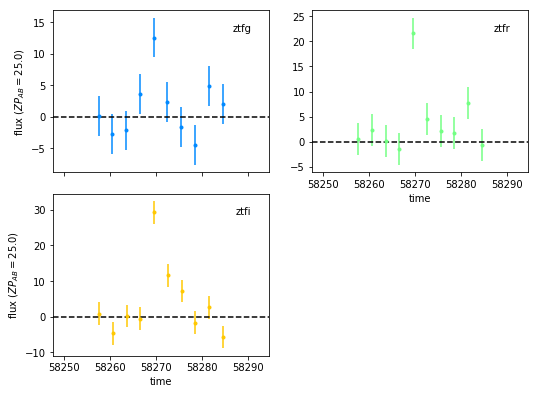

In [22]:
_ = sncosmo.plot_lc(lcs[0])

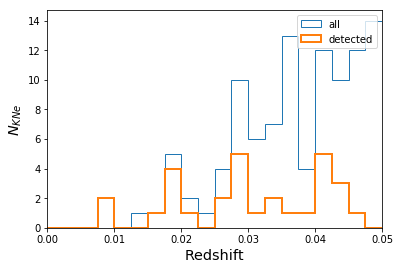

In [23]:
# Redshift distribution
plt.hist(lcs.meta_full['z'], lw=1, histtype='step', range=(0,0.05), bins=20, label='all')
plt.hist(lcs.meta['z'], lw=2, histtype='step', range=(0,0.05), bins=20, label='detected')
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{KNe}$', fontsize='x-large')
plt.xlim((0, 0.05))
plt.legend()

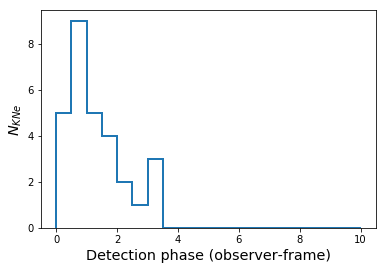

In [24]:
plt.hist(lcs.stats['p_det'], lw=2, histtype='step', range=(0,10), bins=20)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
_ = plt.ylabel(r'$N_{KNe}$', fontsize='x-large')

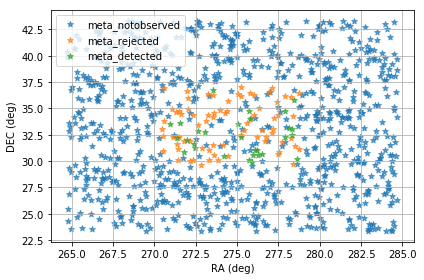

In [25]:
plt.figure()
ax = plt.axes()
ax.grid()

ax.scatter(lcs.meta_notobserved['ra'], lcs.meta_notobserved['dec'], marker='*', label='meta_notobserved', alpha=0.7)
ax.scatter(lcs.meta_rejected['ra'], lcs.meta_rejected['dec'], marker='*', label='meta_rejected', alpha=0.7)
ax.scatter(lcs.meta['ra'], lcs.meta['dec'], marker='*', label='meta_detected', alpha=0.7)

#ax.legend(loc='center left', bbox_to_anchor=(0.9, .5))
ax.legend(loc=0)
ax.set_ylabel('DEC (deg)')
ax.set_xlabel('RA (deg)')

plt.tight_layout()
plt.show()

/Users/anasaguescarracedo/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


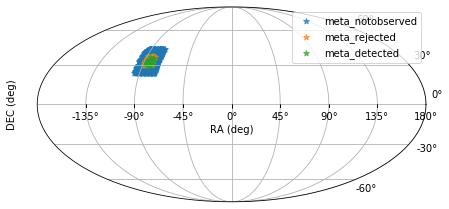

In [26]:
plt.figure()
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='geo degrees mollweide'
    )
ax.grid()

ax.scatter(lcs.meta_notobserved['ra'], lcs.meta_notobserved['dec'],  transform=ax.get_transform('world'), marker='*', label='meta_notobserved', alpha=0.7)
ax.scatter(lcs.meta_rejected['ra'], lcs.meta_rejected['dec'],  transform=ax.get_transform('world'), marker='*', label='meta_rejected', alpha=0.7)
ax.scatter(lcs.meta['ra'], lcs.meta['dec'],  transform=ax.get_transform('world'), marker='*', label='meta_detected', alpha=0.7)

#ax.legend(loc='center left', bbox_to_anchor=(0.9, .5))
ax.legend(loc=0)
ax.set_ylabel('DEC (deg)')
ax.set_xlabel('RA (deg)')

plt.tight_layout()
plt.show()